
# Tugas 1 — Algoritma Machine Learning


## 1) Setup

- Impor library umum
- Atur `random seed`
- Aktifkan **Seaborn theme** untuk visual konsisten
- Siapkan folder output untuk menyimpan gambar


In [23]:

import os
import sys
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    r2_score, accuracy_score, classification_report,
    confusion_matrix, silhouette_score, adjusted_rand_score
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

# Reproducibility
np.random.seed(42)

# Visual style
sns.set_theme(context='notebook', style='whitegrid')

# Output dir
REPORT_DIR = 'D:\KULIAH\SEMESTER 3\MACHINE LEARNING\KELOMPOK\REPORTS'
os.makedirs(REPORT_DIR, exist_ok=True)

print('Python   :', sys.version.split()[0])
print('NumPy    :', np.__version__)
print('Pandas   :', pd.__version__)
print('Seaborn  :', sns.__version__)
print('Sklearn  : OK')
print('Output   :', REPORT_DIR)


Python   : 3.13.7
NumPy    : 2.3.3
Pandas   : 2.3.2
Seaborn  : 0.13.2
Sklearn  : OK
Output   : D:\KULIAH\SEMESTER 3\MACHINE LEARNING\KELOMPOK\REPORTS



## 2) Helper Functions

- `plot_metrics_bar`: barplot metrik dengan label nilai
- `plot_confusion`: heatmap konfusi
- `quick_pairplot`: pairplot fitur + hue (jika ada kolom target kategorikal)


In [24]:

def plot_metrics_bar(title, metrics_dict, ylabel=None, ylim=None, rotate=30, save=None):
    keys, vals = list(metrics_dict.keys()), list(metrics_dict.values())
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(x=keys, y=vals)
    ax.set_title(title)
    if ylabel: ax.set_ylabel(ylabel)
    if ylim: ax.set_ylim(*ylim)
    ax.tick_params(axis='x', rotation=rotate)
    for i, v in enumerate(vals):
        ax.text(i, v + (0.01 if (ylim and ylim[1] <= 1.5) else 0), f"{v:.3f}", ha='center', va='bottom')
    plt.tight_layout()
    if save:
        path = os.path.join(REPORT_DIR, save)
        plt.savefig(path, dpi=300, bbox_inches='tight')
        print('Saved to:', path)
    plt.show()


def plot_confusion(y_true, y_pred, labels=None, title='Confusion Matrix', normalize=True, save=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=labels, yticklabels=labels)
    ax.set_title(title);
    ax.set_xlabel('Predicted');
    ax.set_ylabel('True')
    plt.tight_layout()
    if save:
        path = os.path.join(REPORT_DIR, save)
        plt.savefig(path, dpi=300, bbox_inches='tight')
        print('Saved to:', path)
    plt.show()


def quick_pairplot(df, hue=None, sample=400):
    d = df.copy()
    if len(d) > sample:
        d = d.sample(sample, random_state=42)
    sns.pairplot(d, hue=hue, diag_kind='hist')



## 3) Supervised Learning — Regresi

**Tujuan:** bandingkan beberapa model pada dataset sintetis yang linear-ish.  
**Metrik:** MSE dan R² (lebih besar lebih baik).


In [25]:

def make_regression_df(n=1000):
    X = np.random.randn(n, 4)
    y = 3 * X[:, 0] + 2 * X[:, 1] - X[:, 2] + 0.5 * X[:, 3] + 0.1 * np.random.randn(n)
    cols = ['Temperature', 'Humidity', 'Pressure', 'Wind_Speed']
    df = pd.DataFrame(X, columns=cols);
    df['Target'] = y
    return df


reg_df = make_regression_df()
reg_df.head()


,Temperature,Humidity,Pressure,Wind_Speed,Target
0,0.496714,-0.138264,0.647689,1.523030,1.241091
1,-0.234153,-0.234137,1.579213,0.767435,-2.369350
2,-0.469474,0.542560,-0.463418,-0.465730,-0.090949
3,0.241962,-1.913280,-1.724918,-0.562288,-1.609637
4,-1.012831,0.314247,-0.908024,-1.412304,-2.344812


Saved to: D:\KULIAH\SEMESTER 3\MACHINE LEARNING\KELOMPOK\REPORTS\regression_r2.png


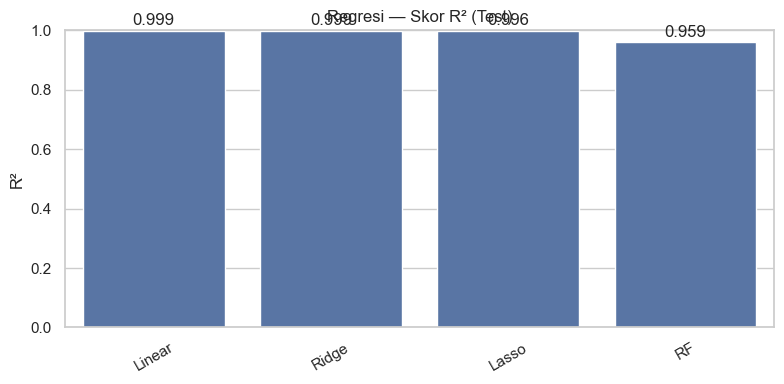

In [26]:

X = reg_df.drop('Target', axis=1)
y = reg_df['Target']

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Linear': Pipeline([('sc', StandardScaler()), ('m', LinearRegression())]),
    'Ridge': Pipeline([('sc', StandardScaler()), ('m', Ridge(alpha=1.0))]),
    'Lasso': Pipeline([('sc', StandardScaler()), ('m', Lasso(alpha=0.1))]),
    'RF': Pipeline([('sc', StandardScaler()), ('m', RandomForestRegressor(n_estimators=120, random_state=42))])
}

reg_scores = {}
for name, pipe in models.items():
    pipe.fit(Xtr, ytr)
    ypred = pipe.predict(Xte)
    reg_scores[name] = r2_score(yte, ypred)

plot_metrics_bar("Regresi — Skor R² (Test)", reg_scores, ylabel='R²', ylim=(0, 1), save='regression_r2.png')



> **Interpretasi cepat:**  
> - Skor **R²** mendekati **1** → model menangkap pola dengan baik.  
> - Jika RF terlalu dominan, cek overfitting dengan **cross_val_score**.



## 4) Supervised Learning — Klasifikasi

**Tujuan:** klasifikasi 3 kelas, bandingkan Logistic, RF, dan SVM.  
Tambahkan **confusion matrix** untuk memantau kelas yang sering tertukar.


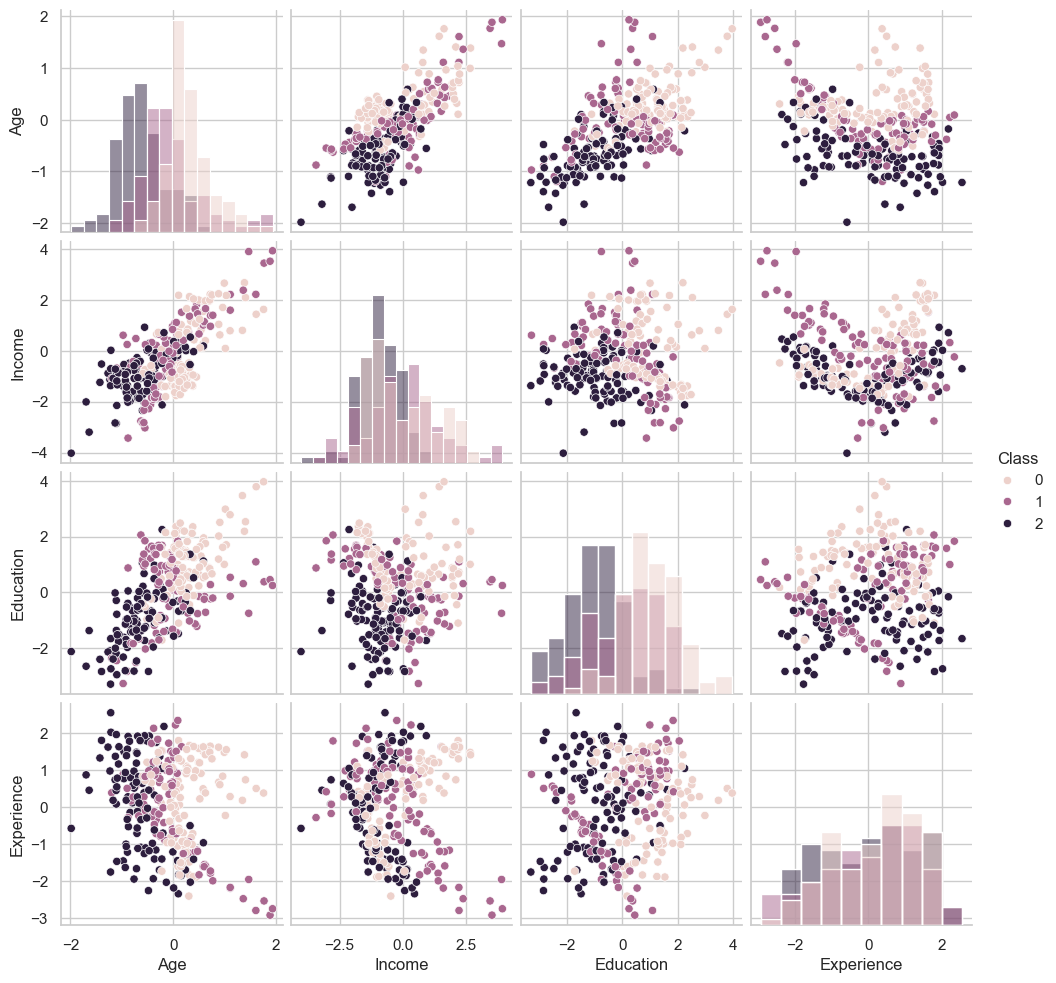

In [27]:

from sklearn.datasets import make_classification


def make_classif_df(n=1000):
    X, y = make_classification(n_samples=n, n_features=4, n_informative=3, n_redundant=1, n_classes=3, random_state=42)
    cols = ['Age', 'Income', 'Education', 'Experience']
    df = pd.DataFrame(X, columns=cols);
    df['Class'] = y
    return df


clf_df = make_classif_df()
quick_pairplot(clf_df, hue='Class', sample=300)


Saved to: D:\KULIAH\SEMESTER 3\MACHINE LEARNING\KELOMPOK\REPORTS\classification_acc.png


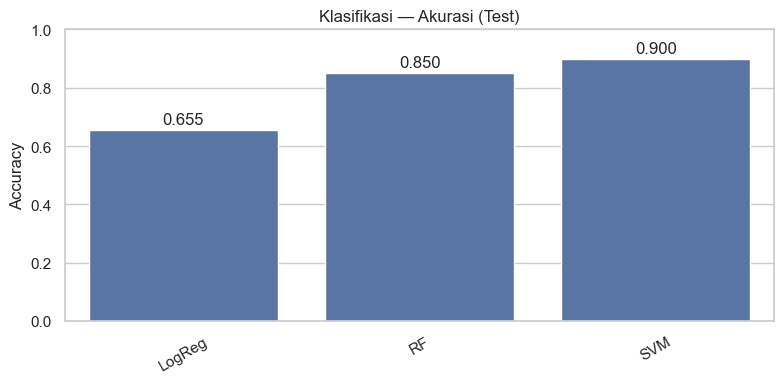

Saved to: D:\KULIAH\SEMESTER 3\MACHINE LEARNING\KELOMPOK\REPORTS\confusion_best.png


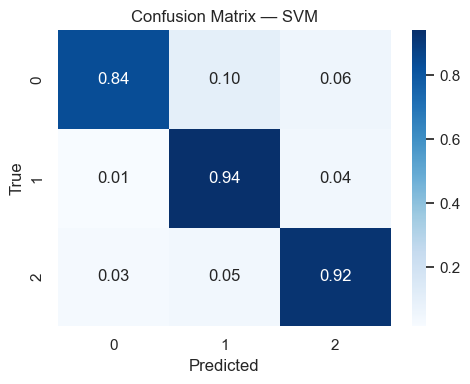

Model terbaik: SVM

              precision    recall  f1-score   support

           0       0.95      0.84      0.89        67
           1       0.86      0.94      0.90        67
           2       0.90      0.92      0.91        66

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200



In [28]:

X = clf_df.drop('Class', axis=1)
y = clf_df['Class']

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf_models = {
    'LogReg': Pipeline([('sc', StandardScaler()), ('m', LogisticRegression(max_iter=1000, random_state=42))]),
    'RF': Pipeline([('sc', StandardScaler()), ('m', RandomForestClassifier(n_estimators=150, random_state=42))]),
    'SVM': Pipeline([('sc', StandardScaler()), ('m', SVC(random_state=42))]),
}

acc = {}
preds = {}
for name, pipe in clf_models.items():
    pipe.fit(Xtr, ytr)
    yp = pipe.predict(Xte)
    preds[name] = yp
    acc[name] = accuracy_score(yte, yp)

plot_metrics_bar("Klasifikasi — Akurasi (Test)", acc, ylabel='Accuracy', ylim=(0, 1), save='classification_acc.png')

# Tampilkan confusion matrix model terbaik
best_name = max(acc, key=acc.get)
plot_confusion(yte, preds[best_name], labels=sorted(y.unique()), title=f'Confusion Matrix — {best_name}',
               save='confusion_best.png')
print(f"Model terbaik: {best_name}\n")
print(classification_report(yte, preds[best_name]))



## 5) Unsupervised — Clustering

**Tujuan:** bandingkan K-Means, Agglomerative, dan DBSCAN pada data 2D; evaluasi dengan **Silhouette** & **ARI**.


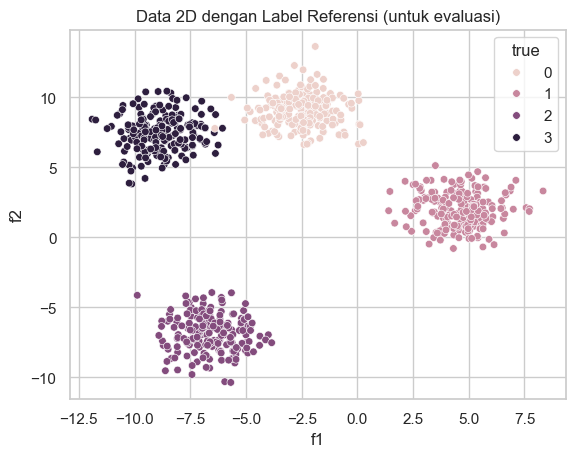

In [29]:

from sklearn.datasets import make_blobs


def make_cluster_df(n=800):
    X, y = make_blobs(n_samples=n, centers=4, cluster_std=1.2, n_features=2, random_state=42)
    df = pd.DataFrame(X, columns=['f1', 'f2']);
    df['true'] = y
    return df


clu_df = make_cluster_df()
sns.scatterplot(data=clu_df, x='f1', y='f2', hue='true', s=30)
plt.title('Data 2D dengan Label Referensi (untuk evaluasi)')
plt.show()


Saved to: D:\KULIAH\SEMESTER 3\MACHINE LEARNING\KELOMPOK\REPORTS\cluster_sil.png


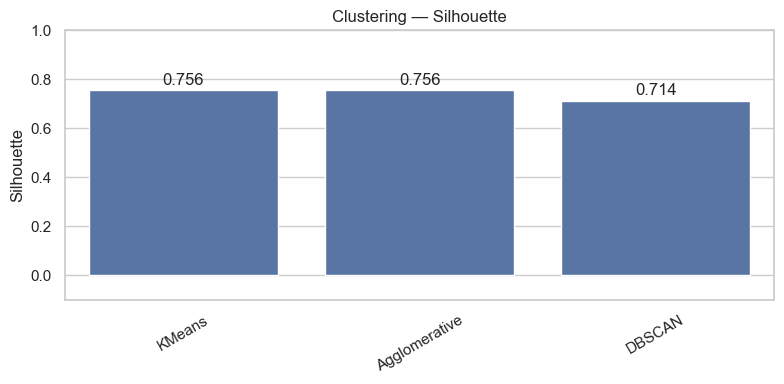

Saved to: D:\KULIAH\SEMESTER 3\MACHINE LEARNING\KELOMPOK\REPORTS\cluster_ari.png


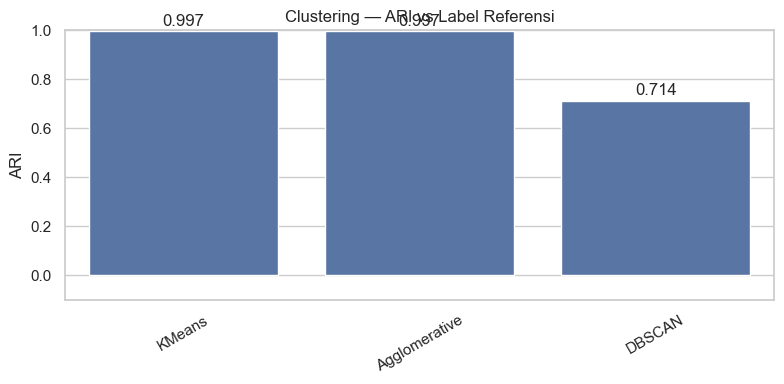

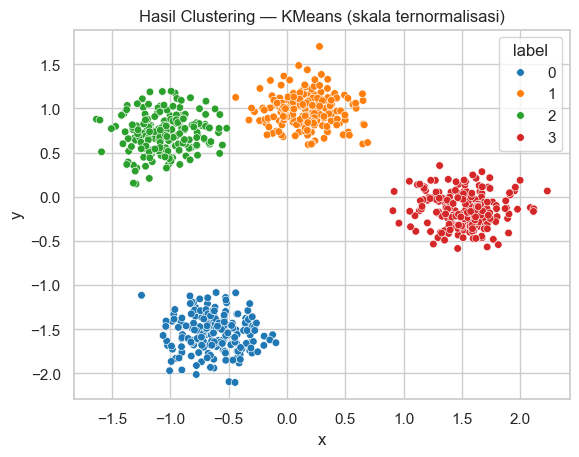

In [30]:

X = clu_df[['f1', 'f2']].values
y_true = clu_df['true'].values

sc = StandardScaler()
Xs = sc.fit_transform(X)

algos = {
    'KMeans': KMeans(n_clusters=4, random_state=42),
    'Agglomerative': AgglomerativeClustering(n_clusters=4),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5),
}

sil, ari, labels_map = {}, {}, {}
for name, algo in algos.items():
    labels = algo.fit_predict(Xs)
    labels_map[name] = labels
    if len(set(labels)) > 1:
        sil[name] = silhouette_score(Xs, labels)
        ari[name] = adjusted_rand_score(y_true, labels)
    else:
        sil[name] = -1;
        ari[name] = -1

plot_metrics_bar("Clustering — Silhouette", sil, ylabel='Silhouette', ylim=(-0.1, 1), save='cluster_sil.png')
plot_metrics_bar("Clustering — ARI vs Label Referensi", ari, ylabel='ARI', ylim=(-0.1, 1), save='cluster_ari.png')

# Visualisasi hasil terbaik berdasar Silhouette
best = max(sil, key=sil.get)
clu_vis = pd.DataFrame(Xs, columns=['x', 'y'])
clu_vis['label'] = labels_map[best]
sns.scatterplot(data=clu_vis, x='x', y='y', hue='label', s=30, palette='tab10')
plt.title(f'Hasil Clustering — {best} (skala ternormalisasi)')
plt.show()



## 6) Unsupervised — Association Rules (Apriori Sederhana)

**Tujuan:** menemukan hubungan A→B sederhana berbasis **support**, **confidence**, **lift**.  
Contoh data transaksi kecil untuk memudahkan pemahaman.


In [31]:

def sample_transactions():
    return [
        ['Bread', 'Milk', 'Eggs'],
        ['Bread', 'Butter', 'Jam'],
        ['Milk', 'Eggs', 'Cheese'],
        ['Bread', 'Milk', 'Butter'],
        ['Eggs', 'Cheese', 'Yogurt'],
        ['Bread', 'Jam', 'Butter'],
        ['Milk', 'Cheese', 'Yogurt'],
        ['Bread', 'Milk', 'Eggs', 'Cheese'],
        ['Butter', 'Jam'],
        ['Milk', 'Yogurt', 'Cheese'],
        ['Bread', 'Butter', 'Eggs'],
        ['Milk', 'Eggs'],
        ['Bread', 'Jam'],
        ['Cheese', 'Yogurt'],
        ['Bread', 'Milk', 'Butter', 'Jam']
    ]


def simple_apriori(transactions, min_support=0.3, min_confidence=0.5):
    items = set(i for t in transactions for i in t)
    n = len(transactions)

    # support 1-item
    support = {}
    for it in items:
        c = sum(1 for t in transactions if it in t)
        s = c / n
        if s >= min_support: support[it] = s

    rules = []
    L = list(support.keys())
    for i, A in enumerate(L):
        for j, B in enumerate(L):
            if i == j: continue
            cAB = sum(1 for t in transactions if A in t and B in t)
            sAB = cAB / n
            if support[A] > 0:
                conf = sAB / support[A]
                if conf >= min_confidence and sAB >= min_support:
                    lift = conf / support[B]
                    rules.append({'A': A, 'B': B, 'support': sAB, 'confidence': conf, 'lift': lift})
    return rules, support


trx = sample_transactions()
rules, sup = simple_apriori(trx)
rules_sorted = sorted(rules, key=lambda x: x['lift'], reverse=True)
pd.DataFrame(rules_sorted[:8]).round(3)


,A,B,support,confidence,lift
0,Bread,Butter,0.333,0.625,1.562
1,Butter,Bread,0.333,0.833,1.562



## 7) Reinforcement Learning — Q-Learning (GridWorld)

**Tujuan:** memahami konsep **Q-Table**: pembaruan nilai berdasar reward & diskonto.  
Agen bergerak di grid 5×5, target di pojok kanan bawah.


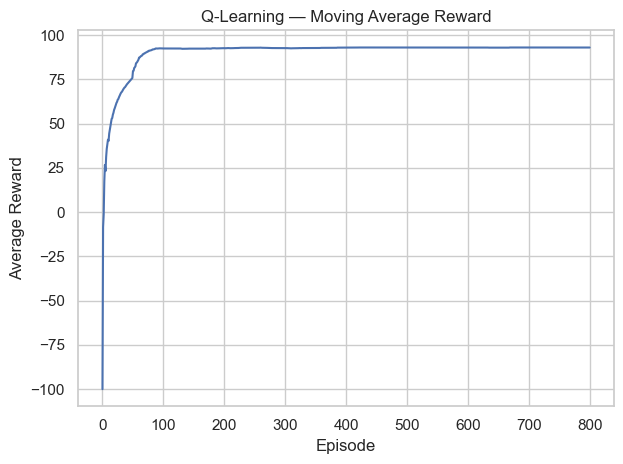

Policy (↑ ↓ ← →), G=Goal, X=Obstacle
  → → ↓ ↓ ↓
  ↑ X → ↓ ↓
  → ↑ X ↓ ↓
  ↓ X → → ↓
  → → → → G


In [32]:

class GridWorld:
    def __init__(self, size=5):
        self.size = size
        self.state = (0, 0)
        self.goal = (size - 1, size - 1)
        self.obstacles = [(1, 1), (2, 2), (3, 1)]

    def reset(self):
        self.state = (0, 0);
        return self.state

    def step(self, a):
        x, y = self.state
        if a == 0:
            x = max(0, x - 1)
        elif a == 1:
            x = min(self.size - 1, x + 1)
        elif a == 2:
            y = max(0, y - 1)
        elif a == 3:
            y = min(self.size - 1, y + 1)
        ns = (x, y)
        if ns in self.obstacles: ns = self.state
        self.state = ns
        if ns == self.goal: return ns, 100, True
        return ns, -1, False

    def idx(self, s):
        return s[0] * self.size + s[1]


def q_learning(env, episodes=800, alpha=0.1, gamma=0.9, epsilon=0.1):
    Q = np.zeros((env.size * env.size, 4))
    rewards = []
    for ep in range(episodes):
        s = env.reset();
        total = 0
        for _ in range(100):
            si = env.idx(s)
            a = np.random.randint(4) if np.random.rand() < epsilon else np.argmax(Q[si])
            s2, r, done = env.step(a)
            s2i = env.idx(s2)
            Q[si, a] += alpha * (r + gamma * np.max(Q[s2i]) - Q[si, a])
            total += r;
            s = s2
            if done: break
        rewards.append(total)
        if epsilon > 0.01: epsilon *= 0.995
    return Q, rewards


env = GridWorld(5)
Q, rewards = q_learning(env)

# Moving average rewards
win = 50
ma = pd.Series(rewards).rolling(win, min_periods=1).mean()
sns.lineplot(x=range(len(ma)), y=ma)
plt.title('Q-Learning — Moving Average Reward')
plt.xlabel('Episode');
plt.ylabel('Average Reward')
plt.tight_layout()
plt.show()


# Policy (panah)
def extract_policy(Q, env):
    P = np.zeros((env.size, env.size), dtype=int)
    for i in range(env.size):
        for j in range(env.size):
            P[i, j] = np.argmax(Q[env.idx((i, j))])
    return P


P = extract_policy(Q, env)
actions = ['↑', '↓', '←', '→']
print('Policy (↑ ↓ ← →), G=Goal, X=Obstacle')
for i in range(env.size):
    row = []
    for j in range(env.size):
        if (i, j) == env.goal:
            row.append('G')
        elif (i, j) in env.obstacles:
            row.append('X')
        else:
            row.append(actions[P[i, j]])
    print(' ', ' '.join(row))



## 8) 18 Studi Kasus — Ringkas & Seaborn

Bagian ini mereplikasi 18 kasus (5 Regresi, 5 Klasifikasi, 5 Clustering, 3 Association) dan menampilkan visual ringkas menggunakan Seaborn.


Accuracy per task:
  Spam      : 0.990
  Heart     : 0.956
  Quality   : 0.958
  Churn     : 0.983
  Sentiment : 0.907


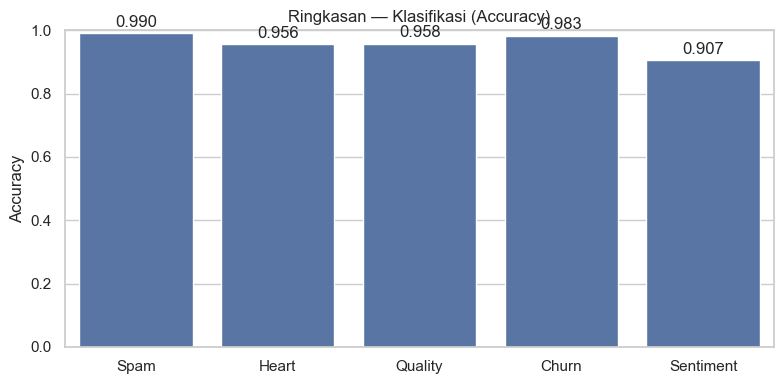

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


# ----- common utility -----
def acc_of(X, y, model):
    """Train/test split, fit model, return accuracy on test split."""
    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=0.2, random_state=42,
        stratify=y if len(np.unique(y)) > 1 else None
    )
    model.fit(Xtr, ytr)
    return accuracy_score(yte, model.predict(Xte))


# ----- dataset generators -----
def cls_spam(n=1000):
    w1 = np.random.exponential(1, n)
    w2 = np.random.exponential(0.5, n)
    ex = np.random.exponential(0.2, n)
    cap = np.random.exponential(10, n)
    s = 0.2 * w1 + 0.5 * w2 + 0.3 * ex + 0.1 * cap
    y = (s > np.percentile(s, 70)).astype(int)
    return pd.DataFrame({'w1': w1, 'w2': w2, 'ex': ex, 'cap': cap}), y


def cls_heart(n=800):
    age = np.random.randint(25, 80, n)
    chol = np.random.normal(200, 40, n)
    mhr = np.random.normal(150, 25, n)
    cp = np.random.randint(0, 4, n)
    p = 0.02 * age + 0.01 * chol - 0.01 * mhr + 0.5 * cp
    y = (p > np.median(p)).astype(int)
    return pd.DataFrame({'age': age, 'chol': chol, 'mhr': mhr, 'cp': cp}), y


def cls_quality(n=600):
    th = np.random.normal(5.0, 0.5, n)
    w = np.random.normal(100, 10, n)
    T = np.random.normal(200, 20, n)
    P = np.random.normal(50, 5, n)
    score = 10 * th + 0.1 * w + 0.05 * T + 0.2 * P
    c = pd.cut(score, 3, labels=['Low', 'Medium', 'High'])
    y = LabelEncoder().fit_transform(c)
    return pd.DataFrame({'th': th, 'w': w, 'T': T, 'P': P}), y


def cls_churn(n=900):
    ten = np.random.randint(1, 72, n)
    m = np.random.normal(65, 20, n)
    tot = ten * m + np.random.normal(0, 100, n)
    ct = np.random.choice([1, 12, 24], n, p=[0.5, 0.3, 0.2])
    p = -0.05 * ten + 0.01 * m - 0.0001 * tot - 0.1 * ct + 3
    y = (p > np.median(p)).astype(int)
    return pd.DataFrame({'ten': ten, 'm': m, 'tot': tot, 'ct': ct}), y


def cls_sent(n=750):
    pos = np.random.poisson(2, n)
    neg = np.random.poisson(1, n)
    exc = np.random.poisson(0.5, n)
    L = np.random.normal(50, 20, n)
    s = 2 * pos - 3 * neg + 0.5 * exc + 0.01 * L
    lab = np.where(s > 1, 'Positive', np.where(s < -1, 'Negative', 'Neutral'))
    y = LabelEncoder().fit_transform(lab)
    return pd.DataFrame({'pos': pos, 'neg': neg, 'exc': exc, 'L': L}), y


spamX, spamy = cls_spam()
heartX, hearty = cls_heart()
qX, qy = cls_quality()
chX, chy = cls_churn()
seX, sey = cls_sent()

clf_scores = {
    'Spam': acc_of(
        spamX, spamy,
        Pipeline([('sc', StandardScaler()), ('m', LogisticRegression(max_iter=1000, random_state=42))])
    ),
    'Heart': acc_of(
        heartX, hearty,
        RandomForestClassifier(n_estimators=150, random_state=42)
    ),
    'Quality': acc_of(
        qX, qy,
        Pipeline([('sc', StandardScaler()), ('m', SVC())])
    ),
    'Churn': acc_of(
        chX, chy,
        DecisionTreeClassifier(max_depth=8, random_state=42)
    ),
    'Sentiment': acc_of(
        seX, sey,
        Pipeline([('sc', StandardScaler()), ('m', LogisticRegression(multi_class='ovr', random_state=42))])
    ),
}

# ----- show summary -----
print("Accuracy per task:")
for k, v in clf_scores.items():
    print(f"  {k:10s}: {v:.3f}")

plot_metrics_bar("Ringkasan — Klasifikasi (Accuracy)", clf_scores, ylabel="Accuracy", ylim=(0, 1))



## 9) Kesimpulan & Saran Pengembangan

- **Seaborn** mempermudah visualisasi eksploratif dan ringkasan metrik.
- **Pipeline** (sklearn) menyederhanakan preprocessing + model dalam satu objek.
- Dataset sintetis memudahkan pemahaman; untuk data nyata, cukup ganti fungsi pembuat data dengan loader CSV dan pakai pipeline yang sama.

**Lanjutan yang disarankan:**
- Tambahkan **GridSearchCV** untuk tuning hiperparameter.
- Tambahkan **cross-validation** untuk estimasi generalisasi yang lebih stabil.
- Simpan model ke disk dengan `joblib` agar mudah dipakai ulang.
